In [75]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Parâmetros de detecção de anomalias
X_menor = 22          # Valor mínimo para detecção de anomalias
X_maior = 28          # Valor máximo para detecção de anomalias
X_tempo = 5           # Número de leituras consecutivas fora do intervalo
X_tempo1 = 5          # Número de leituras consecutivas sem variação
X_porc = 0.05         # Porcentagem de variação aceitável
X_pontos = 10         # Número de pontos anteriores para cálculo da média
X_diferenca = 15      # Diferença máxima permitida entre leituras consecutivas
X_osc = 1             # Número de oscilações permitidas em curto intervalo
X_pontos_mediana = 10 # Número de pontos anteriores para cálculo da mediana
X_desvio_mediana = 10 # Desvio permitido em relação à mediana
X_tendencia = 5       # Leituras consecutivas para verificar tendência
X_corr_limiar = 1.0   # Limite de correlação esperado entre duas métricas
X_tempo_critico = 10  # Número de leituras consecutivas no intervalo crítico

In [88]:
# Caminho do banco de dados
db_path = 'C:/Users/Dell/Documents/2-PROJETOS EMBARCADOS/LEITURA_MODBUS_SERIAL/modbus_data1.db'

# Conexão com o banco de dados SQLite
con = sqlite3.connect(db_path)

# Consulta ajustada para obter valores de umidade
query = "SELECT timestamp, value FROM reorganized_readings WHERE categoria = 'umidade'"

# Lê os dados do banco em um DataFrame
df = pd.read_sql_query(query, con)

# Fecha a conexão
con.close()

In [90]:
# ================================================
# 1) PRÉ-PROCESSAMENTO
# ================================================
# Remove valores nulos ou infinitos
df = df.dropna(subset=['value'])
df = df[df['value'].apply(np.isfinite)]

# Converte o timestamp para datetime e calcula as horas
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hora'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60

# Inicializa a coluna de anomalias e detalhes
anomalies = []
anomaly_details = []
anomaly_counts = {}

C:\Users\Dell\AppData\Local\Temp\ipykernel_27904\3055924333.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


In [92]:
# ================================================
# 2) DETECÇÃO DE ANOMALIAS
# ================================================
for i in range(len(df)):
    value = df.loc[i, 'value']
    reasons = []

    # Regra 1: Valor fora do intervalo por X_tempo leituras consecutivas
    if i >= X_tempo - 1:
        if all((df.loc[j, 'value'] < X_menor or df.loc[j, 'value'] > X_maior) for j in range(i - X_tempo + 1, i + 1)):
            reasons.append("Fora do intervalo")
            anomaly_counts["Fora do intervalo"] = anomaly_counts.get("Fora do intervalo", 0) + 1

    # Regra 2: Sem variação por X_tempo1 leituras consecutivas
    if i >= X_tempo1 - 1:
        if all(df.loc[j, 'value'] == df.loc[j - 1, 'value'] for j in range(i - X_tempo1 + 2, i + 1)):
            reasons.append("Sem variação")
            anomaly_counts["Sem variação"] = anomaly_counts.get("Sem variação", 0) + 1

    # Regra 3: Variação muito grande com base na média dos últimos X_pontos
    if i >= X_pontos:
        mean_previous = df.loc[i - X_pontos:i - 1, 'value'].mean()
        if abs(value - mean_previous) > mean_previous * X_porc:
            reasons.append("Variação muito grande")
            anomaly_counts["Variação muito grande"] = anomaly_counts.get("Variação muito grande", 0) + 1

    # Regra 4: Mudança abrupta em curto período
    if i > 0:
        if abs(df.loc[i, 'value'] - df.loc[i - 1, 'value']) > X_diferenca:
            reasons.append("Mudança abrupta")
            anomaly_counts["Mudança abrupta"] = anomaly_counts.get("Mudança abrupta", 0) + 1

    # Regra 5: Oscilações frequentes em curto intervalo
    if i >= X_osc:
        oscillations = sum(
            abs(df.loc[j, 'value'] - df.loc[j - 1, 'value']) > X_diferenca
            for j in range(i - X_osc + 1, i + 1)
        )
        if oscillations >= X_osc:
            reasons.append("Oscilações frequentes")
            anomaly_counts["Oscilações frequentes"] = anomaly_counts.get("Oscilações frequentes", 0) + 1

    # Regra 6: Desvio relativo à mediana
    if i >= X_pontos_mediana:
        median_previous = df.loc[i - X_pontos_mediana:i - 1, 'value'].median()
        if abs(value - median_previous) > X_desvio_mediana:
            reasons.append("Desvio da mediana")
            anomaly_counts["Desvio da mediana"] = anomaly_counts.get("Desvio da mediana", 0) + 1

    # Regra 7: Tendência prolongada
    if i >= X_tendencia:
        tendencia = all(
            df.loc[j, 'value'] > df.loc[j - 1, 'value']
            for j in range(i - X_tendencia + 1, i + 1)
        ) or all(
            df.loc[j, 'value'] < df.loc[j - 1, 'value']
            for j in range(i - X_tendencia + 1, i + 1)
        )
        if tendencia:
            reasons.append("Tendência prolongada")
            anomaly_counts["Tendência prolongada"] = anomaly_counts.get("Tendência prolongada", 0) + 1

    # Regra 8: Duração excessiva no intervalo crítico
    if i >= X_tempo_critico - 1:
        if all(70 <= df.loc[j, 'value'] <= 80 for j in range(i - X_tempo_critico + 1, i + 1)):
            reasons.append("Intervalo crítico prolongado")
            anomaly_counts["Intervalo crítico prolongado"] = anomaly_counts.get("Intervalo crítico prolongado", 0) + 1

    # Adiciona os resultados
    anomalies.append(len(reasons) > 0)
    anomaly_details.append(", ".join(reasons))

# Adiciona as anomalias e os detalhes ao DataFrame
df['Anomaly'] = anomalies
df['Anomaly_Details'] = anomaly_details

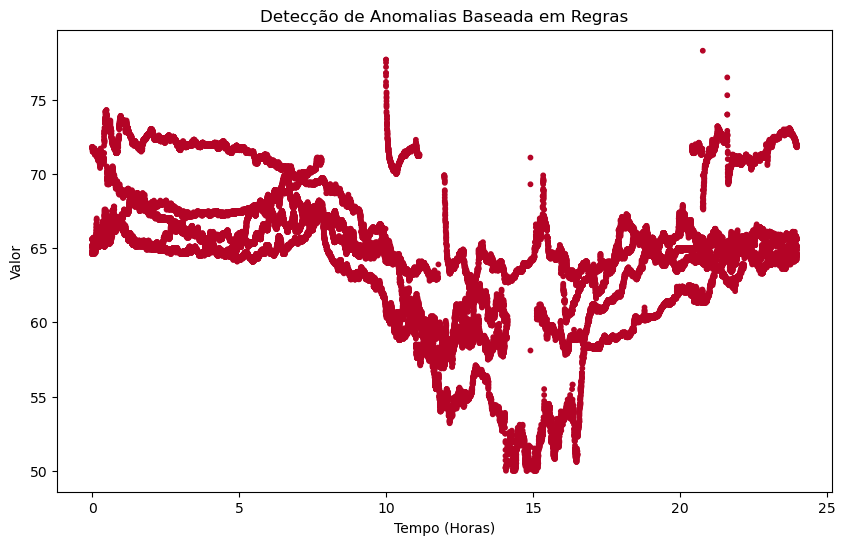

Leituras anômalas encontradas:
Total de leituras anômalas: 64894

Quantidade de anomalias por tipo:
Fora do intervalo: 64894
Intervalo crítico prolongado: 8045
Sem variação: 16963
Variação muito grande: 32
Tendência prolongada: 166
Mudança abrupta: 1
Oscilações frequentes: 1
Desvio da mediana: 2


In [95]:

# ================================================
# 4) GRÁFICO DE DETECÇÃO DE ANOMALIAS
# ================================================
plt.figure(figsize=(10, 6))
plt.scatter(df['hora'], df['value'], c=df['Anomaly'], cmap='coolwarm', s=10)
plt.title('Detecção de Anomalias Baseada em Regras')
plt.xlabel('Tempo (Horas)')
plt.ylabel('Valor')
plt.show()

# ================================================
# 3) RELATÓRIO DE ANOMALIAS
# ================================================
anomalous_data = df[df['Anomaly']]
print("Leituras anômalas encontradas:")
#print(anomalous_data[['timestamp', 'value', 'Anomalyt_Deails']])
print(f"Total de leituras anômalas: {len(anomalous_data)}")
print("\nQuantidade de anomalias por tipo:")

for anomaly_type, count in anomaly_counts.items():
    print(f"{anomaly_type}: {count}")